# Models with censored observations

In many practical applications, some of the observations in a timeseries
will be censored. Left-censored observations are known to be on the left
(lower than) a given threshold, and vice versa, right-censored values are above a given threshold,
but the precise value of the observation is not known.

A simplistic approach is to replace the censored observation with some "intermediate" value.
For instance, if the observation is positive and left-censored, 
than we could use the mid point between $0$ and the threshold. However, this leads to all sorts
of biases. Another approach is to impute the (partially) missing value, for instance with the EM algorithm,
or by modeling the missing values as latent variables in a Bayesian model.

A third approach is to "integrate out" the missing values. If the observation $X$ is modeled with 
a density function $f_X(x | \theta)$, then for e.g. left-cencored values below threshold $t$, we replace
the density with a cumulative density function (CDF) $F_X(t) = \int_{-\infty}^t f_X(x) dx$.

In Stan, we can do this by replacing sampling statements like
```
x ~ normal(mu, sigma);
```
with statements that add the log-CDF to the `target' variable
```
target += normal_lcdf(x | mu, sigma);
```
In the case of right-censored observations, you would use `normal_lccdf` --- the complementary CDF or "survival function".

A good example of data with many left-censored values is timeseries of HIV-1 viral load (VL) measurements.
The VL measures the number of viral RNA copies in a mL of blood plasma, but the assay for detecting viral RNA
typically has a limit of detection of 50 copies per mL (older assays had LODs of 200 copies per mL, and there are super-precise assays that have a lower LOD than 50).

longitudinal VL measurement can to see if antiretroviral treatment is working, and with modeling such timeseries have been used to reveal some of the kinetic parameters of HIV-1. Here we simulate HIV-1 VL timeseries, assuming a simple model of an HIV-1 infection. At a certain time point, the simulated subjects are treated with ART, and their VL starts to decline. 
With the 50 copies per mL assay, the VL is not detectible early in the infection, and again after ART is controlling the virus.

First we will generate some data. We'll use the `solve_ivp` function from `scipy.integrate` to generate "typical" viral load timeseries. Of course, we could use HBOMS to generate data for us, but we don't have to. If you want to test your model with random data, it can even help to use a different framework for simulation: this way you might catch some mistakes. You could even make the simulated data more complex than what is assumed in the HBOMS model to test robustness against model mis-specification. But that's a different subject. 

The model is a typical viral dynamic model of the form. 

$$ \frac{dT}{dt} = \lambda - d_T T - \beta V T / T_0 $$
$$ \frac{dI}{dt} = \beta V T / T_0 - d_I I $$

Here $T$ is the concentration of the target cell population: for HIV-1 these are the helper T cells (or CD4+ T cells).
The variable $I$ is the concentration of the infected cell population. The variable $V$ is the viral load, and for convenience we 
assume that this is proportional to $I$, and we rescale everything such that $V = I$. 

The error model for viral load is often assumed to be log-normal. Hence, we will generate noisy observations by sampling from a log-normal distribution with location parameter $\log(I)$ and scale parameter $\sigma$. Realizations that fall below the LOD of $50$ copies per mL are replaced by this threshold.

HBOMS understands the following censor codes (using integer values):
* uncensored observation have censor code 0, for these we use the log PDF
* left censored observations have censor code -1, for these we use the log CDF
* right censored observations have censor code 1, for these we use the log cCDF
* missing observations have censor code 2, these are just ignored.

In cases like this, missing values might as well be left ut of the data, but there are cases where we want to include missing observations explicitly.

In addition to the observed values (the VL), we will also provide the HBOMS model with a censor code for each of them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.integrate import solve_ivp
from scipy.special import expit

# define "ground truth" parameter values

T0_pop = 1e6 ## initial number of target cells
d_T_pop = 0.05 ## death rate of target cells
d_I_pop = 0.5 ## death rate of infected cells
beta_pop = 1.7 ## infection rate
lam_pop = T0_pop * d_T_pop ## production rate of target cells
I0_pop = 0.1 ## initial number of infected cells
sigma = 0.5 ## measurement noise
lod = 50.0 ## limit of detection
tau = 40.0 ## ART initiation time: 40 days post infection

# define the ODE model. See equations above

def vd_ode(t, y, T0, d_T, d_I, beta, lam, tau):
    T, I = y
    betat = beta * (1-expit(5*(t - tau)))
    return np.array([
        lam - d_T * T - betat * T * I / T0, 
        betat * T * I / T0 - d_I * I
    ])

# function to generate a VL timeseries with noise and censoring

def gen_vd_data(params, N, tmax, lod=None):
    T0, d_T, d_I, beta, lam, I0, sigma, tau = params
    t_span = (0, tmax)
    ObsTime = np.linspace(tmax/N, tmax, N)
    y0 = [T0, I0]
    sol = solve_ivp(
        lambda t, y: vd_ode(t, y, T0, d_T, d_I, beta, lam, tau),
        t_span, y0, dense_output=True, t_eval=ObsTime
    )
    Ihat = sol.y[1]
    VL = sts.lognorm.rvs(scale=Ihat, s=sigma)
    if lod is None:
        CC = [0 for _ in VL] # censor code 0 means no censoring
    else:
        CC = [-1 if x < lod else 0 for x in VL] # censor code -1 means left-censored
        VL = [lod if x < lod else x for x in VL]
    return ObsTime, Ihat, VL, CC, sol

### Test python model

Let's have a look at what the python simulations generate. We'll plot 20 data point
using the above_defined ground-truth parameters. 
We'll plot the deterministic trajectories, as well as the VL measurements.

In the VL graph, red dots correspond to censored observations

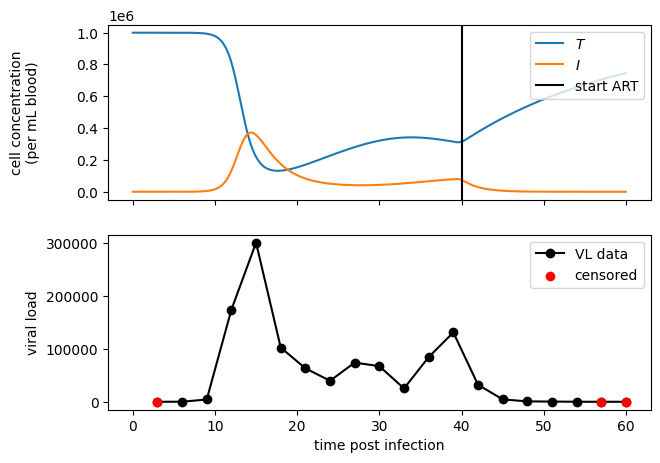

In [2]:
N = 20
tmax = 60

param_vals = (T0_pop, d_T_pop, d_I_pop, beta_pop, lam_pop, I0_pop, sigma, tau)

ObsTime, Ihat, VL, CC, sol = gen_vd_data(param_vals, N, tmax, lod=lod)

fig, axs = plt.subplots(2, 1, figsize=(7,5), sharex=True)
ts = np.linspace(0, tmax, 1000)
labs = ["$T$", "$I$"]
for i in range(2):
    axs[0].plot(ts, sol.sol(ts)[i], label=labs[i])
axs[0].axvline(x=tau, label="start ART", color='k')
axs[0].legend(loc=1)
axs[0].set_ylabel("cell concentration\n(per mL blood)")

color = ['k' if c == 0 else 'r' for c in CC]
axs[1].plot(ObsTime, VL, color='k', label="VL data", marker='o', zorder=1)
cens = [c != 0 for c in CC]
axs[1].scatter(ObsTime[cens], np.array(VL)[cens], color='r', label='censored', zorder=2)
axs[1].legend(loc=1)
axs[1].set_xlabel("time post infection")
axs[1].set_ylabel("viral load")

fig.align_ylabels()

### Generate a panel of VL timeseries

Next, we'll generate a number of timeseries, each with slightly different parameter values to simulate differences between individuals and viral fitness.
We will also add some variation in the time when ART is initialted ($\tau$), although we'll assume that this time is known and 
keep it constant.
We also assume that $T_0$ is known and equal for everybody. This is unrealistic, but we'll do it to make things a bit simpler.

In [28]:
# function for simulating parameter sets with random effects.

def gen_vd_params(d_I, d_T, beta, I0, omega):
    d_I_ran = d_I * sts.lognorm.rvs(s=omega)
    d_T_ran = d_T * sts.lognorm.rvs(s=omega)
    beta_ran = beta * sts.lognorm.rvs(s=omega)
    I0_ran = I0 * sts.lognorm.rvs(s=omega)
    return (d_I_ran, d_T_ran, beta_ran, I0_ran)

R = 12 ## number of replicates
omega = 0.15 ## amount of parameter variation between individuals


# add variation in tau
tau_indiv = sts.norm.rvs(loc=tau, scale=5, size=R)

# lists that will contain the data
VLs = []
CCs = []
ObsTimes = []

# loop to generate data
for r in range(R):
    N = 20 # 20 measurements
    tmax = 3*N # one measurement each 3 days
    # generate inter-individual variation
    d_I, d_T, beta, I0 = gen_vd_params(d_I_pop, d_T_pop, beta_pop, I0_pop, omega)
    param_vals = (T0_pop, d_T, d_I, beta, d_T*T0_pop, I0, sigma, tau_indiv[r])
    # generate observations with noise and censoring
    ObsTime, Ihat, VL, CC, sol = gen_vd_data(param_vals, N, tmax, lod=lod)
    ObsTimes.append(ObsTime)
    VLs.append(VL)
    CCs.append(CC)

### Plot the data

Have a look at each of the $R$ timeseries. Again, censored observations are indicated with red dots

Text(0.5, 0, 'days post infection')

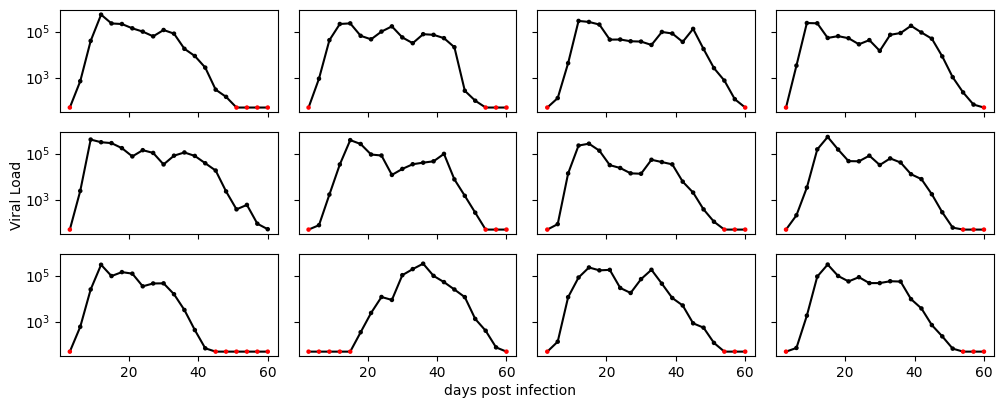

In [29]:
nrows = 3
fig, axs = plt.subplots(nrows, R//nrows, figsize=(10,4), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    t = ObsTimes[i]
    VL = VLs[i]
    CC = CCs[i]
    ax.plot(t, VL, color='k', zorder=1)
    color = ['k' if c == 0 else 'r' for c in CC]
    ax.scatter(t, VL, s=5, color=color, zorder=2)
    ax.set_yscale('log')
    
fig.tight_layout()
fig.text(0, 0.5, "Viral Load", rotation=90, va='center')
fig.text(0.5, 0, "days post infection", ha='center')

### Define and compile the HBOMS model

For defining the parameters, we will add random effects to $I_0$, $d_T$, $\beta$ and $d_I$.
We'll assume that $T_0$ is a global constant, and that $\sigma$ is unknown, but the same for each participant.
The ART initiation time is known, but can differ between individual. We therefore define it as `"const_indiv"`.

In the ODEs, we'll use the expit function to switch from pre-ART to ART. In Stan, this function is called `inv_logit` (because expit is the inverse of logit). For these systems, it often helps to use a ODE solver for stiff systems. We can specify this using the options argument of the `HbomsModel` constructor.

To specify that our observations (VL) can be censored, we use the `censored=True` option in the `Observation` constructor. 
If we do this, the HBOMS model expects that in addition to a `VL` field in the data, we also provide a `cc_VL` field. 

In [30]:
import hboms.utilities as util
import hboms

params = [
    hboms.Parameter("T0", 1e6, "const"),
    hboms.Parameter("I0", 0.1, "random"),
    hboms.Parameter("d_T", 0.05, "random"), 
    hboms.Parameter("beta", 1.7, "random"),
    hboms.Parameter("d_I", 0.5, "random"),
    hboms.Parameter("sigma", 0.5, "fixed"),
    hboms.Parameter("tau", list(tau_indiv), "const_indiv")
]

# use inv_logit to switch to the ART phase

odes = """
real betat = beta * (1 - inv_logit(5*(t-tau)));
ddt_T = T0 * d_T - d_T * T - betat * I * T / T0;
ddt_I = betat * I * T / T0 - d_I * I;
"""

init = """
T_0 = T0;
I_0 = I0;
"""

# use Stan's BDF integrator (backward-differentiation formula)

options = {
    "integrator" : "ode_bdf_tol"
}

# the VL gets a log-normal distribution and contains censored values

hbm = hboms.HbomsModel(
    name="vd_model", 
    odes=odes, 
    init=init, 
    dists=[
        hboms.StanDist("lognormal", "VL", params=["log(I)", "sigma"])
    ], 
    params=params, 
    state=[
        hboms.Variable("T"), 
        hboms.Variable("I")
    ], 
    obs=[
        hboms.Observation("VL", censored=True)
    ],
    options=options
)

util.show_stan_model(hbm.model_code)

### Gather data and check initial parameter guess

We now put all data in a python dictionary with the correct keys, and as usual, 
we want to see if our initial parameter guesses are any good. 

16:39:25 - cmdstanpy - INFO - CmdStan start processing
16:39:25 - cmdstanpy - INFO - Chain [1] start processing
16:39:25 - cmdstanpy - INFO - Chain [1] done processing


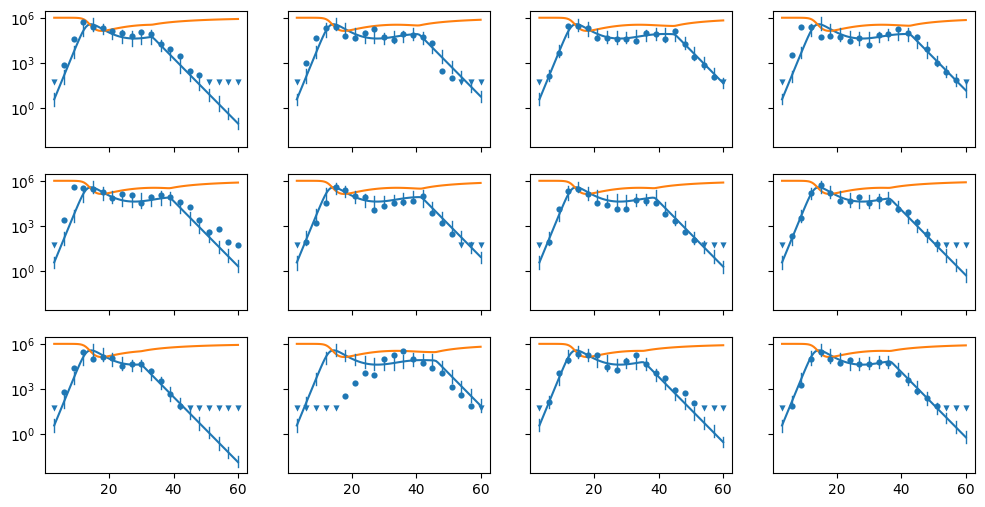

In [31]:
data = {
    "VL" : VLs,
    "cc_VL" : CCs,
    "Time" : ObsTimes
}

fig = hbm.init_check(data, yscale="log", state_var_names=["I", "T"])

### Fit the model

Then, finally, we are ready to fit the model to the simulated data.
We'll use $R$ CPU threads.

When the fit tis complete, we'll look at the posterior predictive checks.
In this graph, left-lensored values are indicated by a downward-pointing triangle. Uncensored values are indicated by circles.

In [32]:
hbm.sample(
    data=data,
    iter_sampling=200, iter_warmup=200, 
    refresh=1, show_progress="notebook",
    chains=1, threads_per_chain=R,
    step_size=0.01
)

16:39:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

16:43:24 - cmdstanpy - INFO - CmdStan done processing.
16:43:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in 'vd_model.stan', line 52, column 31 to column 74) (in 'vd_model.stan', line 132, column 12 to column 70)
	Exception: Exception: lognormal_lcdf: Location parameter is -nan, but must be finite! (in 'vd_model.stan', line 51, column 27 to column 70) (in 'vd_model.stan', line 132, column 12 to column 70)
Consider re-running with show_console=True if the above output is unclear!
16:43:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (1.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


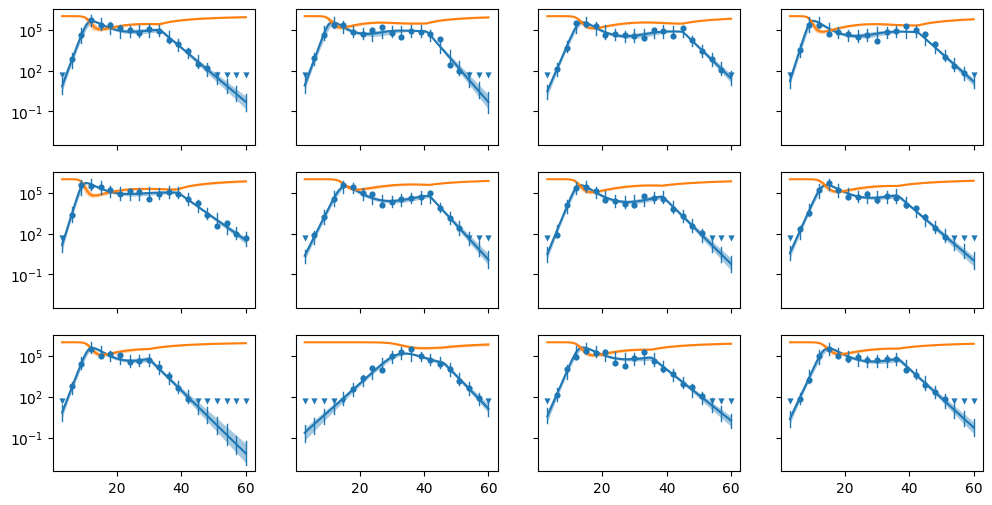

In [33]:
fig = hbm.post_pred_check(data, yscale="log", state_var_names=["I", "T"])

### What happens if we ignore censoring?

Let's see what would happen to the fit if we decide to just ignore the fact that 50 copies per mL is the limit of detection, 
and treat these values as actual observed viral loads. For this, we set all the censor codes to zero, and re-fit the model.

As expected, the fits looks pretty bad, and the measurement error is much larger than before.

In [37]:
bad_data = data.copy()
bad_data["cc_VL"] = [[0 for x in xs] for xs in bad_data["cc_VL"]]

bad_sam = hbm.sample(
    data=bad_data,
    iter_sampling=200, iter_warmup=200, 
    refresh=1, show_progress="notebook",
    chains=1, threads_per_chain=R,
    step_size=0.01
)

16:46:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

16:49:11 - cmdstanpy - INFO - CmdStan done processing.
16:49:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (1.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


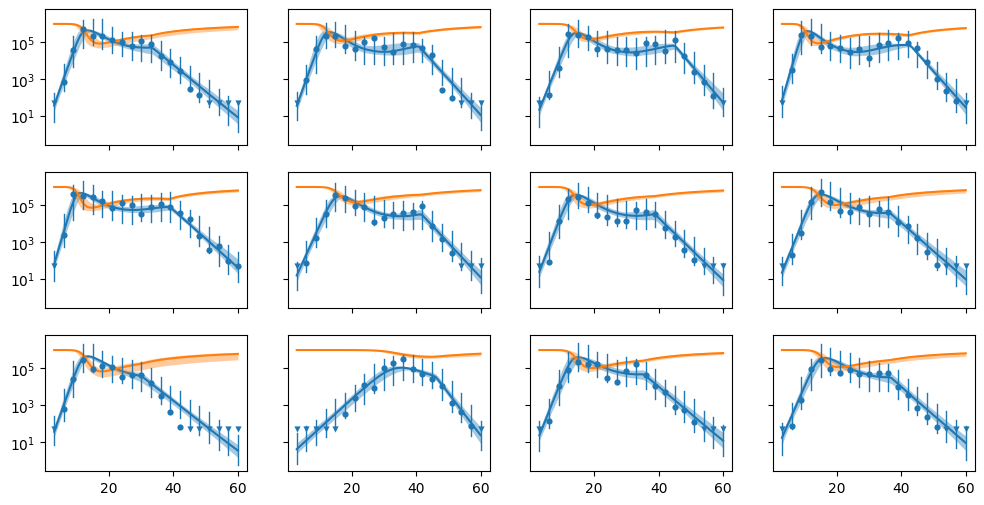

In [38]:
fig = hbm.post_pred_check(data, yscale="log", state_var_names=["I", "T"])